In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from transformers import BertModel, BertConfig

# Step 1: Load the dataset
dataset_path = '../../data/data.csv'
data = pd.read_csv(dataset_path)

# Step 2: Define target and feature columns
target_column = 'Sint'
feature_columns = [col for col in data.columns if col not in ['ID', 'e_Sint', 'Sint']]

# Step 3: Handle missing values and normalize
data.fillna(data.mean(numeric_only=True), inplace=True)
data[feature_columns] = (data[feature_columns] - data[feature_columns].mean()) / data[feature_columns].std()


/home/sasuke/miniconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-16 08:30:27.381910: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 08:30:27.396969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755333027.415688   20349 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755333027.421337   20349 cuda_blas.cc:1

In [ ]:

# Step 4: Dataset class
class SintDataset(Dataset):
    def __init__(self, df, feature_columns, target_column):
        self.X = df[feature_columns].values
        self.y = df[target_column].values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Step 5: Transformer regression model
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim):
        super(TransformerRegressor, self).__init__()
        self.feature_mapper = nn.Linear(input_dim, 64)
        config = BertConfig(
            hidden_size=64,
            num_hidden_layers=4,
            num_attention_heads=4,
            intermediate_size=256,
            max_position_embeddings=512,
            vocab_size=30522
        )
        self.transformer = BertModel(config)
        self.regressor = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.feature_mapper(x)
        x = self.transformer(inputs_embeds=x.unsqueeze(1)).last_hidden_state[:, 0, :]
        return self.regressor(x)

# Step 6: Model setup
input_dim = len(feature_columns)
model = TransformerRegressor(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
actuals = []
predictions = []



In [5]:
for fold, (train_idx, test_idx) in enumerate(kf.split(data), start=1):
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

    train_loader = DataLoader(SintDataset(train_data, feature_columns, target_column), batch_size=32, shuffle=True)
    test_loader = DataLoader(SintDataset(test_data, feature_columns, target_column), batch_size=32, shuffle=False)

    # Train
    model.train()
    for epoch in range(10):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.flatten(), y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            y_true.extend(y_batch.numpy())
            y_pred.extend(output.flatten().numpy())

    actuals.extend(y_true)
    predictions.extend(y_pred)

R²: 0.4531
MAE: 1.4776 with accuracy: 99.69%
RMSE: 10.4363 with accuracy: 97.78%
MSE: 56.5544 with accuracy: 87.95%


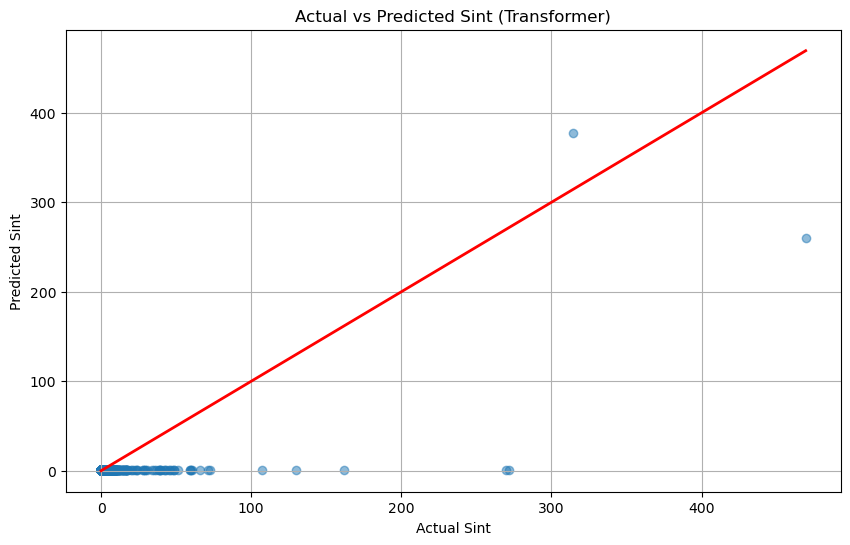

In [7]:
# Step 8: Evaluation metrics
r2 = r2_score(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(actuals, predictions)

range_val = max(actuals) - min(actuals)
mae_accuracy = (1 - mae / range_val) * 100
mse_accuracy = (1 - mse / range_val) * 100
rmse_accuracy = (1 - rmse / range_val) * 100

# Step 9: Print results
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f} with accuracy: {mae_accuracy:.2f}%')
print(f'RMSE: {rmse:.4f} with accuracy: {rmse_accuracy:.2f}%')
print(f'MSE: {mse:.4f} with accuracy: {mse_accuracy:.2f}%')

# Step 10: Plot
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', lw=2)
plt.xlabel('Actual Sint')
plt.ylabel('Predicted Sint')
plt.title('Actual vs Predicted Sint (Transformer)')
plt.grid(True)
plt.show()